Eğitim seti yükleniyor...
Found 2630 files belonging to 2 classes.
Validasyon seti yükleniyor...
Found 563 files belonging to 2 classes.
Test seti yükleniyor...
Found 566 files belonging to 2 classes.


Model: "V12_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,402 (368.76 KB)

 Trainable params: 93,954 (367.01 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7160 - loss: 0.6875
Epoch 1: val_loss improved from inf to 0.51079, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 341ms/step - accuracy: 0.7167 - loss: 0.6858 - val_accuracy: 0.8028 - val_loss: 0.5108 - learning_rate: 0.0010
Epoch 2/30
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8571 - loss: 0.3722
Epoch 2: val_loss improved from 0.51079 to 0.41544, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - accuracy: 0.8572 - loss: 0.3717 - val_accuracy: 0.8064 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 3/30
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8842 - loss: 0.2963
Epoch 3: val_loss improved from 0.41544 to 0.33443, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.8842 - loss: 0.2963 - val_accuracy: 0.8668 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0

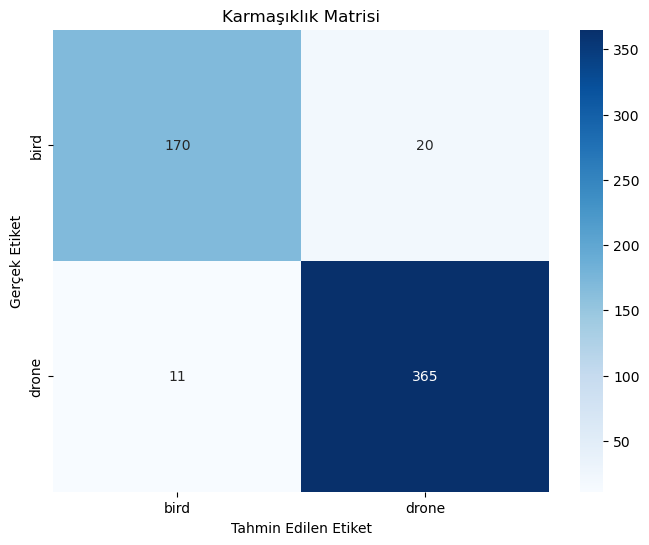

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

BASE_PATH = "C:/Users/mkasl/Desktop/donem5/yap470/Ara_rapor_ 1/final_dataset1" 
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
VALID_PATH = os.path.join(BASE_PATH, 'valid')
TEST_PATH = os.path.join(BASE_PATH, 'test')

IMAGE_SIZE = (128, 128) 
BATCH_SIZE = 32

tf.random.set_seed(42) #aynı sonucu vermesi için bunu gerçi dosyalara test train valid olarak ayırıyoruz
#tekrarlanabilirliği sağlıyor
EPOCHS = 30 

print("Eğitim seti yükleniyor...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=42)

print("Validasyon seti yükleniyor...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)

print("Test seti yükleniyor...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH, labels='inferred', label_mode='categorical',
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, shuffle=False)
class_names = train_dataset.class_names #Görselleştirmede kullanıyorum 

#Toplam batch sayısını bulma
#Oranlara göre batch sayısı hesaplama
#Önce test setini ayır sonra valid sonra train 
#data augmentation yeni veriler üretip yapay olarak overfittingi önlemeye çalışıyorum
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

#Burası cache gibi önbellekleme vs. kullanıp performansı arttırmaya çalıştığım kısım ama buna rağmen daha farklı şeylere
#ihtiyacım var prefecthi sonraki batchi hazırlar cache önbelleğe alır
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential(name="V12_Model")
model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
#1. blok
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1"))
model.add(tf.keras.layers.BatchNormalization(name="bn1"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name="pool1"))
#2. blok
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="conv2"))
model.add(tf.keras.layers.BatchNormalization(name="bn2"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name="pool2"))
#3. blok
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv3"))
model.add(tf.keras.layers.BatchNormalization(name="bn3"))
model.add(tf.keras.layers.MaxPooling2D((2, 2), name="pool3"))
#GlobalAveragePooling2D ile sınıflandırma eskiden burasında flatten ve dense katmanı vardı
model.add(tf.keras.layers.GlobalAveragePooling2D(name="global_pool"))
model.add(tf.keras.layers.Dropout(0.5, name="dropout"))
model.add(tf.keras.layers.Dense(2, activation='softmax', name="output"))
model.summary()

#default olan adam optimizer kullanıyorum
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
#Bu modelimde değiştirdiğim kısım
#Veri setindeki dosya sayılarını buluyorum ardından sınıfları sayıya göre ağırlıklandırıyorum
num_birds = len(os.listdir(os.path.join(TRAIN_PATH, 'bird'))) #sayma
num_drones = len(os.listdir(os.path.join(TRAIN_PATH, 'drone'))) #sayma
total_train_samples = num_birds + num_drones
#Ağırlıkları hesaplama
weight_for_bird = (1 / num_birds) * (total_train_samples / 2.0)
weight_for_drone = (1 / num_drones) * (total_train_samples / 2.0)
class_weights = {class_names.index('bird'): weight_for_bird, class_names.index('drone'): weight_for_drone}

# patience=5 olarak güncelledim öğrenme oranına ve sınıflandırmaya adapte olması için
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#En iyi modeli kaydeder earlystopping için gerekli.
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
#çok iyi başarım gösteren v10 modelimden dinamik öğrenme
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001) #dinamik öğrenme

EPOCHS = 30 #EarlyStopping'in 
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS,
  callbacks=[early_stopping, model_checkpoint, reduce_lr],
  class_weight=class_weights #Bu modelde yeni eklediğim parametre
)
#history'den eğitim ve validasyon metriklerini alıyorum.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#Gerçekte kaç epoch çalıştığını history listesinin uzunluğundan anlıyorum.
actual_epochs = len(acc) 
epochs_range = range(actual_epochs) #X eksenini dinamik olarak ayarlıyorum.
test_loss, test_accuracy = model.evaluate(test_dataset) #accuracy hesaplama 
print(f"\nTest Seti Doğruluğu: {test_accuracy:.4f}")
print(f"Test Seti Kaybı: {test_loss:.4f}")
#Test setindeki tüm resimler için tahminleri al
y_pred_probs = model.predict(test_dataset) #karmaşıklık matrisi
y_pred = np.argmax(y_pred_probs, axis=1)
#gerçek etiketleri al
y_true = []
for images, labels in test_dataset:
  y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()